In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from IPython.display import clear_output

''' this is an adapted version of ricky's ode_demo.py '''


" this is an adapted version of ricky's ode_demo.py "

In [ ]:
from cosmoNODE.loaders import Anode as A
device = torch.device('cpu')

In [ ]:
from cosmoNODE.loaders import LC

In [93]:
adjoint = False

viz = True
viz_at_end = True
data_size = 350
batch_time = 25
batch_size = 175

test_freq = 5

In [3]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [4]:
a = A()
dataloader = DataLoader(a)
item = a[0]
lc = item[0]
obj_class = item[1]
lc = lc.squeeze()

In [193]:
mjds = lc[:, 0]
fluxes = lc[:, 1]
flux_y0 = fluxes[0].reshape(1, -1) # torch.Size([1, 1])
true_f = fluxes.reshape(-1, 1, 1)

TypeError: list indices must be integers or slices, not tuple

In [6]:
true_y0 = torch.tensor([[2., 0.]]) # torch.Size([1, 2])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

In [94]:
def flux_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_f[s]  # (M, D)
    batch_t = mjds[:batch_time]  # (T)
    batch_y = torch.stack([true_f[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [95]:
batch_1 = flux_batch()
batch_2 = flux_batch()

In [96]:
by0_f, bt_f, by_f = flux_batch()
print(f'by0_f.shape : {by0_f.shape}, bt_f.shape: {bt_f.shape}, by_f.shape: {by_f.shape}')

by0_f.shape : torch.Size([175, 1, 1]), bt_f.shape: torch.Size([25]), by_f.shape: torch.Size([25, 175, 1, 1])


In [9]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [10]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [11]:
by0_f, bt_f, by_f = flux_batch()
# by0, bt, by = get_batch()

In [12]:
# print(f'by0.shape : {by0.shape}, bt.shape: {bt.shape}, by.shape: {by.shape}')
print(f'by0.shape : {by0_f.shape}, bt.shape: {bt_f.shape}, by.shape: {by_f.shape}')

by0.shape : torch.Size([50, 1, 1]), bt.shape: torch.Size([25]), by.shape: torch.Size([25, 50, 1, 1])


In [13]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

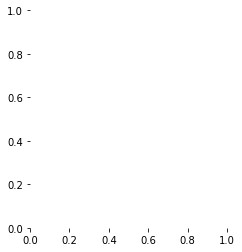

In [15]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
# ax_phase = fig.add_subplot(132, frameon=False)
# ax_vecfield = fig.add_subplot(133, frameon=False)
plt.show(block=False)

In [16]:
def visualize(true_y, pred_y, odefunc, itr):
    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('mjd')
    ax_traj.set_ylabel('flux')
    ax_traj.plot(mjds.numpy(), true_y.numpy()[:, 0, 0])
    ax_traj.plot(mjds.numpy(), pred_y.numpy()[:, 0, 0], '--')
    ax_traj.set_xlim(mjds.min(), mjds.max())
#     ax_traj.set_ylim(-2, 2)
    ax_traj.legend()

#     ax_phase.cla()
#     ax_phase.set_title('Phase Portrait')
#     ax_phase.set_xlabel('x')
#     ax_phase.set_ylabel('y')
#     ax_phase.plot(true_y.numpy()[:, 0], true_y.numpy()[:, 1], 'g-')
#     ax_phase.plot(pred_y.numpy()[:, 0], pred_y.numpy()[:, 1], 'b--')
#     ax_phase.set_xlim(0, )
#     ax_phase.set_ylim(-2, 2)

#     ax_vecfield.cla()
#     ax_vecfield.set_title('Learned Vector Field')
#     ax_vecfield.set_xlabel('x')
#     ax_vecfield.set_ylabel('mjd')

#     y, x = np.mgrid[-2:2:21j, -2:2:21j]
#     dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
#     mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
#     dydt = (dydt / mag)
#     dydt = dydt.reshape(21, 21, 2)

#     ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
#     ax_vecfield.set_xlim(-2, 2)
#     ax_vecfield.set_ylim(-2, 2)

    fig.tight_layout()
#     plt.savefig('png/{:03d}'.format(itr))
    plt.show()
    plt.pause(0.001)


In [89]:
epochs = 5
niters = 100
odefunc = ODEFunc()
optimizer = optim.RMSprop(odefunc.parameters(), lr=1e-1)
ii = 0
losses = []
# itr = 1

Iter 0060 | Total Loss 228201.546875


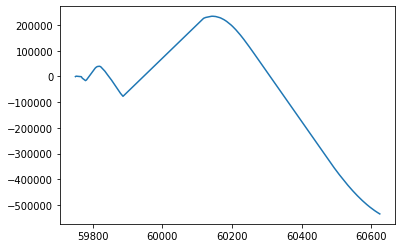

61
62
63
64


KeyboardInterrupt: 

In [97]:
for epoch in range(1, epochs+1):    
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        by0_f, bt_f, by_f = flux_batch()
        pred_f = odeint(odefunc, by0_f, bt_f, rtol=10, atol=5)
        loss = torch.mean(torch.abs(pred_f - by_f))
        loss.backward()
        optimizer.step()
#         print(itr)
        if itr % test_freq == 0:
            with torch.no_grad():
                clear_output()
                pred_f = odeint(odefunc, flux_y0, mjds, rtol=10, atol=5)
                loss = torch.mean(torch.abs(pred_f - true_f))
                losses.append(loss)
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                plt.plot(mjds.tolist(), pred_f.flatten().tolist())
                plt.show()
                ii += 1    

In [ ]:
# print(losses)

pred_f = odeint(odefunc, flux_y0, mjds)
# visualize(true_f, pred_f.detach(), odefunc, itr)




In [ ]:
# without batching
# true_f all of the fluxes

flat_f = true_f.flatten()
plt.plot(mjds.tolist(), flat_f.tolist())

In [88]:
# true_f.numpy()[:, 0, 1]
pred_f.detach().numpy()[:, 0, 0]
# , t.numpy(), true_y.numpy()[:, 0, 1]

array([[-113.58843 ],
       [-113.55888 ],
       [-113.52935 ],
       [-113.49985 ],
       [-105.703514],
       [-105.672455],
       [-105.64139 ],
       [-105.594795],
       [-105.5482  ],
       [ -47.674652]], dtype=float32)

In [101]:
from cosmoNODE.loaders import LC

In [192]:
lc = LC() # light curve but treating different passbands as distinct lightcurves

In [134]:
def ode_batch(time_sols, flux_sols):
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=True))
#     print(s)
    batch_y0 = flux_sols[s]  # (M, D)
    batch_t = time_sols[:batch_time]  # (T)
    batch_y = torch.stack([flux_sols[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [139]:
curve = lc[0][['mjd', 'flux']]
times = torch.tensor(curve['mjd'].values.tolist())


flux_list = torch.tensor(curve['flux'].values.tolist())
flux_0 = flux_list[0].reshape(1, -1) # torch.Size([1, 1])
fluxes = flux_list.reshape(-1, 1, 1)

data_size = len(fluxes) - 1
batch_time = data_size//10
batch_size = data_size

batch = ode_batch(times, fluxes)
batch[0].shape

torch.Size([62, 1, 1])

In [183]:
epochs = 5
niters = 100
odefunc = ODEFunc()
optimizer = optim.RMSprop(odefunc.parameters(), lr=1e-3)
ii = 0
losses = []
# itr = 1

In [184]:
eval_times = torch.tensor(np.linspace(times.min(), times.max(), num=100))

In [189]:
r_tol = 1
a_tol = 1

Iter 0005 | Total Loss 205.669403


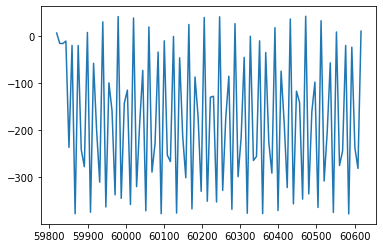

Iter 0010 | Total Loss 148.564270


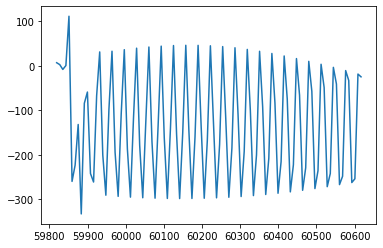

Iter 0015 | Total Loss 2396.403809


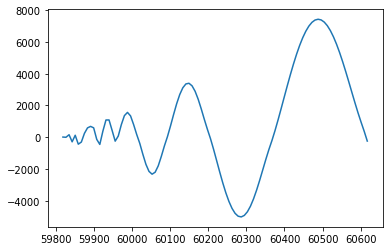

Iter 0020 | Total Loss 177.164932


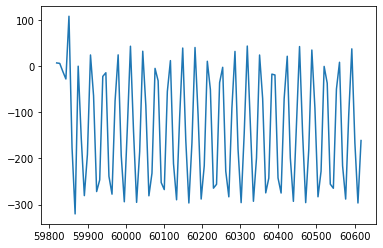

Iter 0025 | Total Loss 128.958862


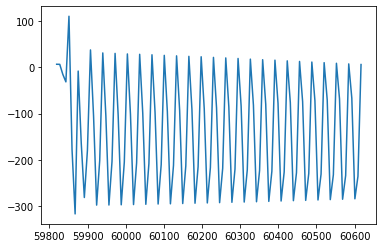

Iter 0030 | Total Loss 2942.991211


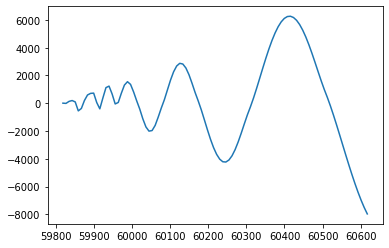

Iter 0035 | Total Loss 146.889603


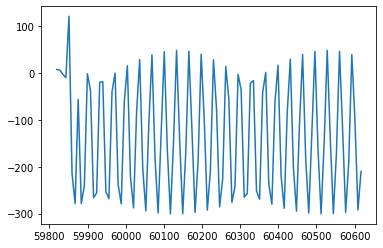

Iter 0040 | Total Loss 2745.043701


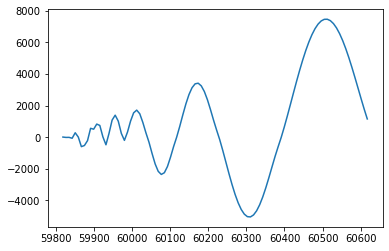

Iter 0045 | Total Loss 154.459381


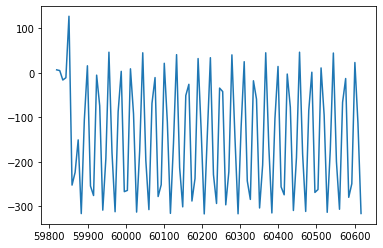

Iter 0050 | Total Loss 160.833710


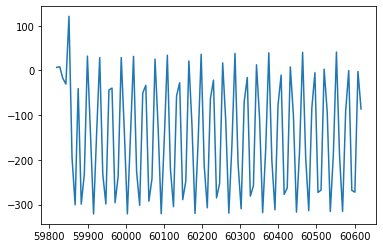

Iter 0055 | Total Loss 155.638092


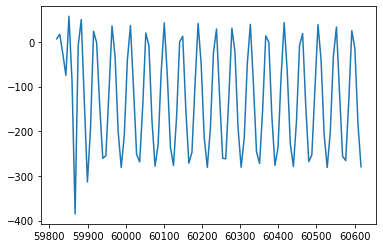

Iter 0060 | Total Loss 195.038696


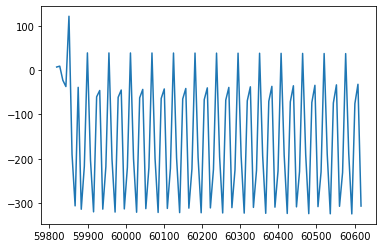

Iter 0065 | Total Loss 197.079727


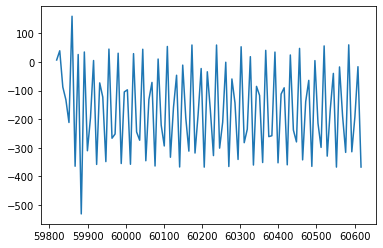

Iter 0070 | Total Loss 208.415009


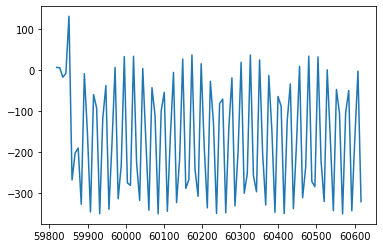

Iter 0075 | Total Loss 197.527130


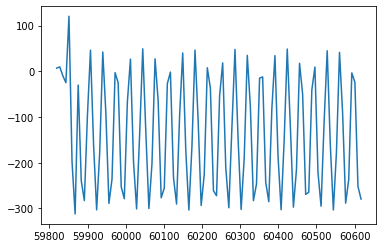

Iter 0080 | Total Loss 3965.553955


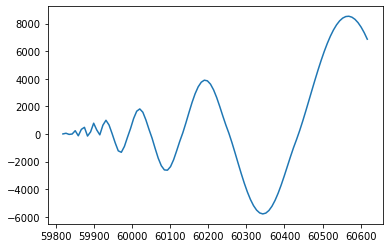

Iter 0085 | Total Loss 3228.277344


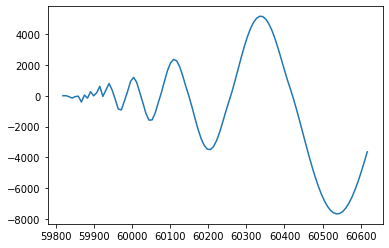

Iter 0090 | Total Loss 2753.253906


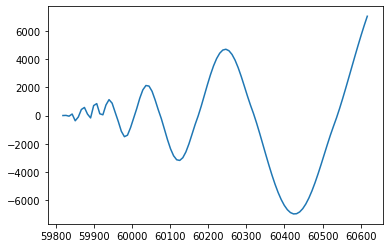

Iter 0095 | Total Loss 1010.143188


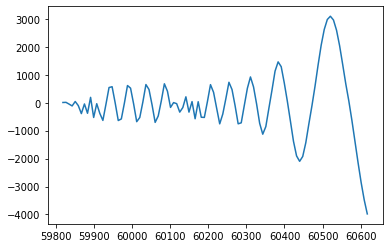

Iter 0100 | Total Loss 3889.717041


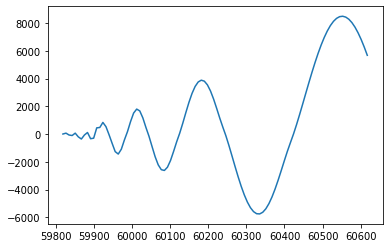

Iter 0005 | Total Loss 2090.833740


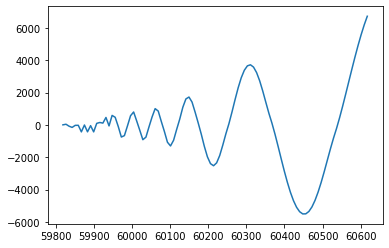

Iter 0010 | Total Loss 170.416061


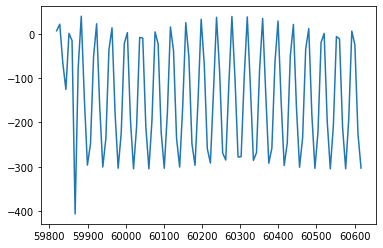

Iter 0015 | Total Loss 1909.451050


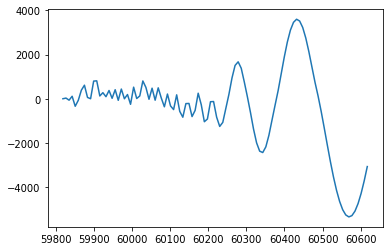

Iter 0020 | Total Loss 166.532623


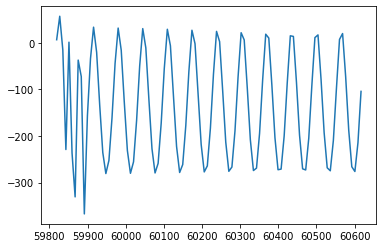

Iter 0025 | Total Loss 2974.290283


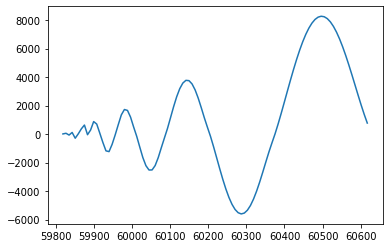

Iter 0030 | Total Loss 2038.826538


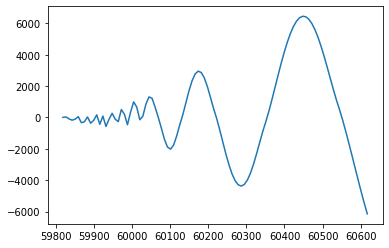

Iter 0035 | Total Loss 2681.347900


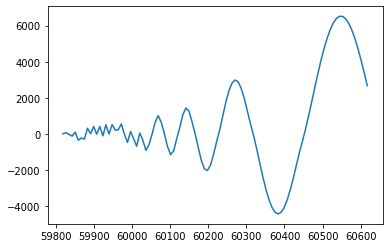

Iter 0040 | Total Loss 2987.917480


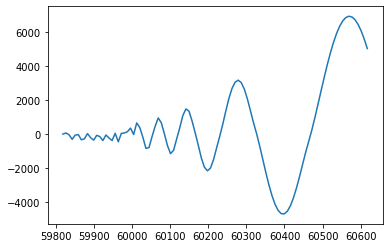

Iter 0045 | Total Loss 167.629761


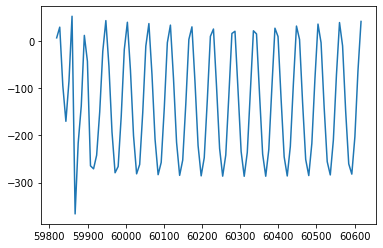

Iter 0050 | Total Loss 133.107513


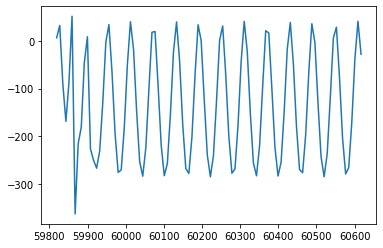

Iter 0055 | Total Loss 219.513794


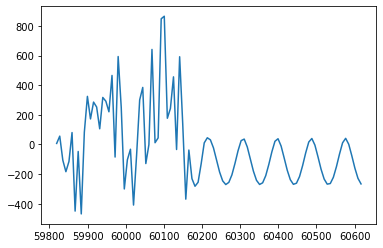

Iter 0060 | Total Loss 175.412857


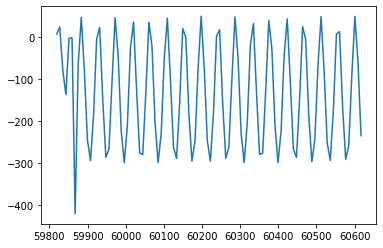

Iter 0065 | Total Loss 179.515503


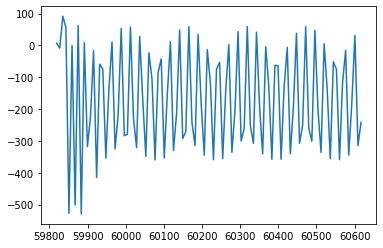

Iter 0070 | Total Loss 141.711212


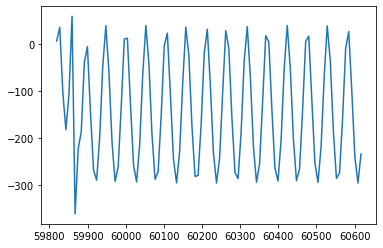

Iter 0075 | Total Loss 2396.103516


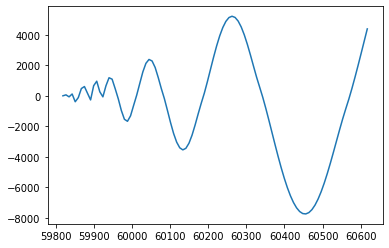

Iter 0080 | Total Loss 3186.174316


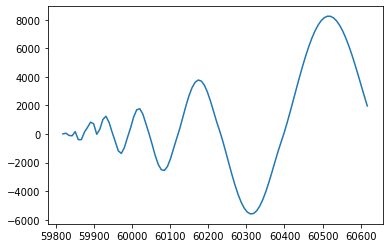

Iter 0085 | Total Loss 2887.902588


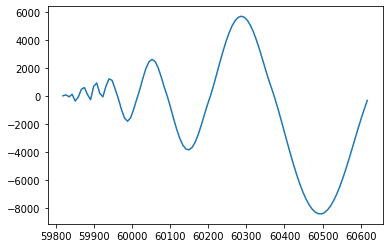

Iter 0090 | Total Loss 2945.786133


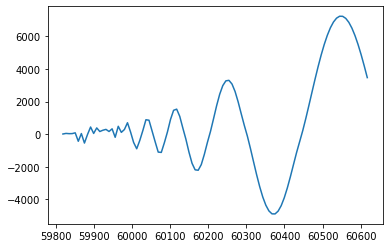

Iter 0095 | Total Loss 154.245300


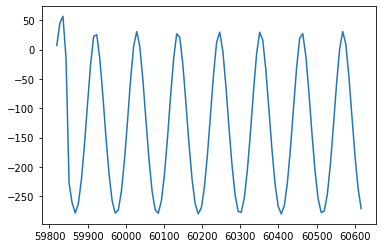

Iter 0100 | Total Loss 151.113144


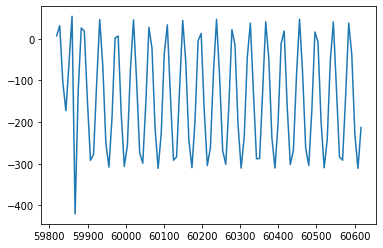

Iter 0005 | Total Loss 317.433380


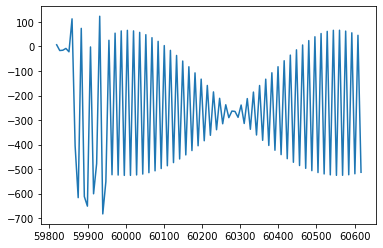

Iter 0010 | Total Loss 1652.867798


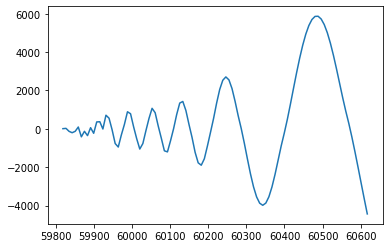

Iter 0015 | Total Loss 212.733841


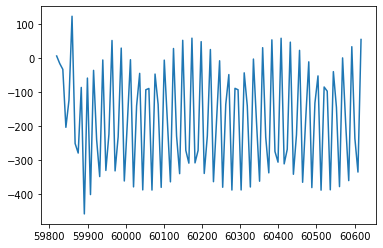

Iter 0020 | Total Loss 572.480286


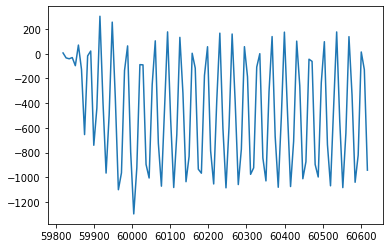

Iter 0025 | Total Loss 1557.190430


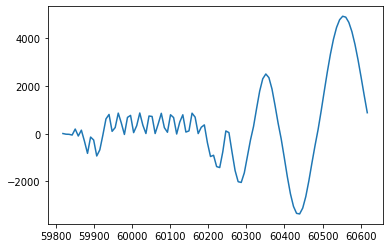

Iter 0030 | Total Loss 188.038651


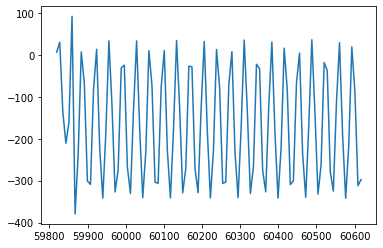

Iter 0035 | Total Loss 1312.854614


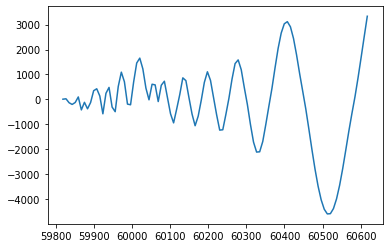

Iter 0040 | Total Loss 187.691345


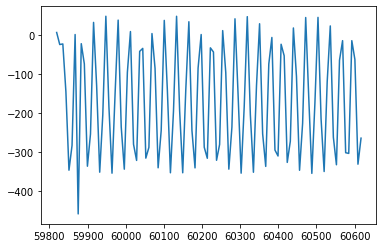

Iter 0045 | Total Loss 2416.842285


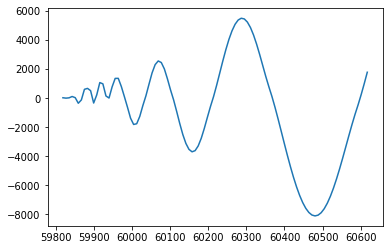

Iter 0050 | Total Loss 2776.697021


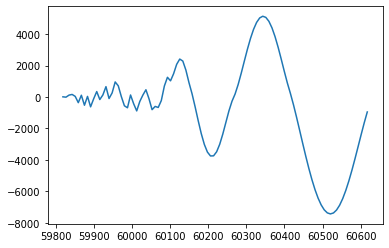

Iter 0055 | Total Loss 3706.268799


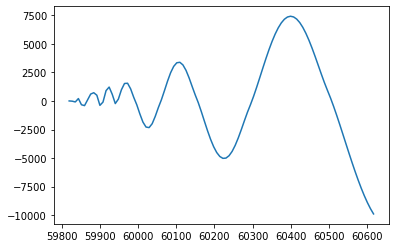

Iter 0060 | Total Loss 4205.436523


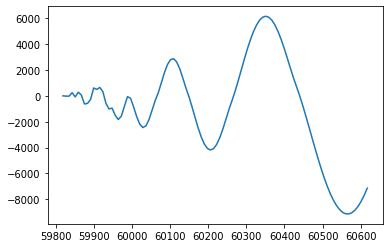

Iter 0065 | Total Loss 3434.338379


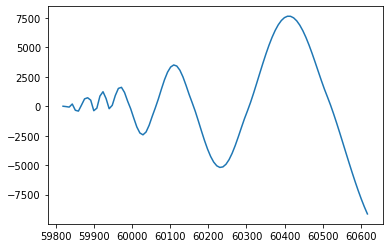

Iter 0070 | Total Loss 2865.859863


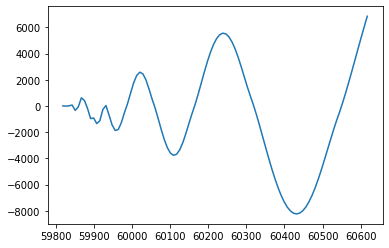

Iter 0075 | Total Loss 1407.168213


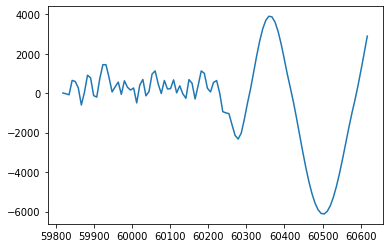

Iter 0080 | Total Loss 156.711823


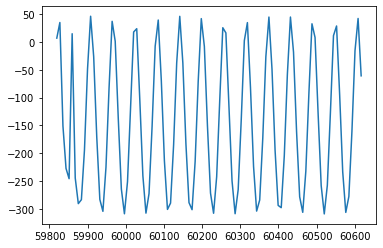

Iter 0085 | Total Loss 175.906876


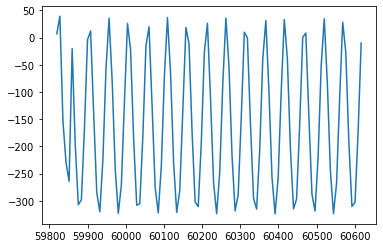

Iter 0090 | Total Loss 171.024246


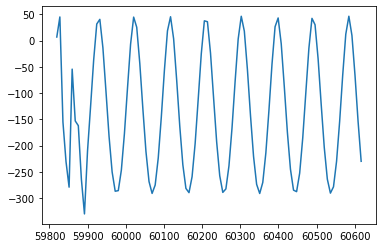

Iter 0095 | Total Loss 2127.030518


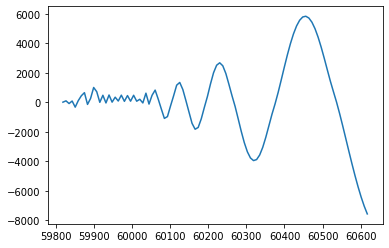

Iter 0100 | Total Loss 2094.991943


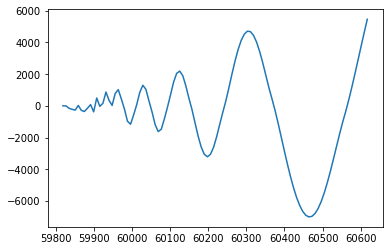

Iter 0005 | Total Loss 3381.582275


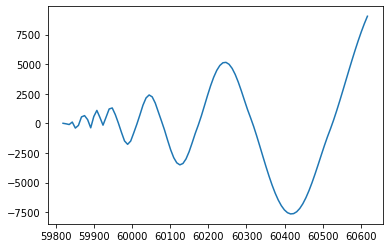

Iter 0010 | Total Loss 188.705139


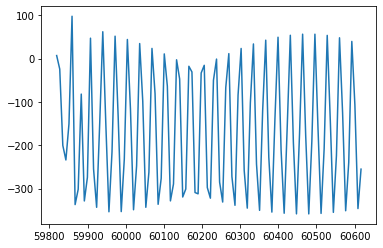

Iter 0015 | Total Loss 755.955688


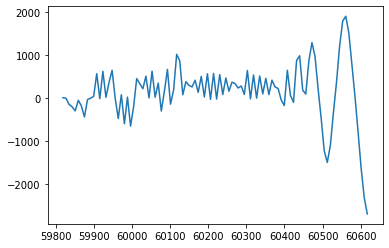

Iter 0020 | Total Loss 163.004684


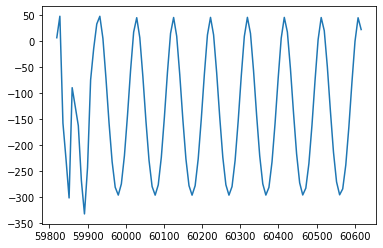

Iter 0025 | Total Loss 161.883438


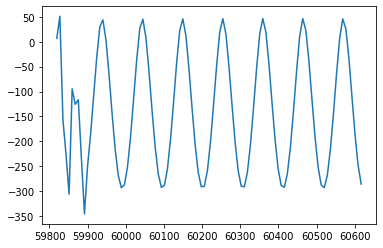

Iter 0030 | Total Loss 4459.757812


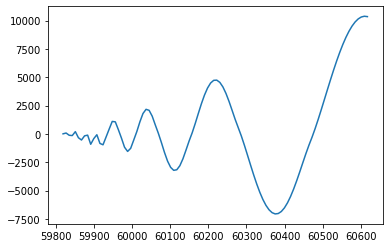

Iter 0035 | Total Loss 4170.839844


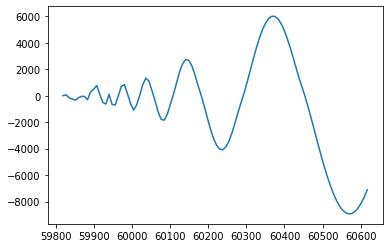

Iter 0040 | Total Loss 4576.297852


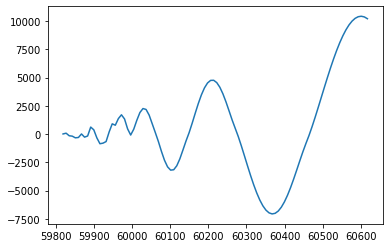

Iter 0045 | Total Loss 2197.650635


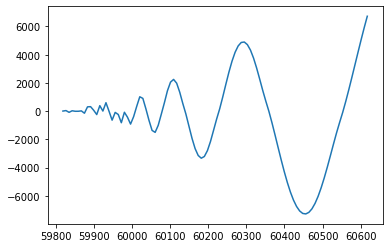

Iter 0050 | Total Loss 132.198807


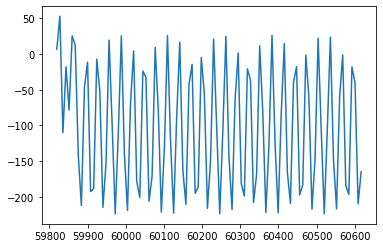

Iter 0055 | Total Loss 132.482483


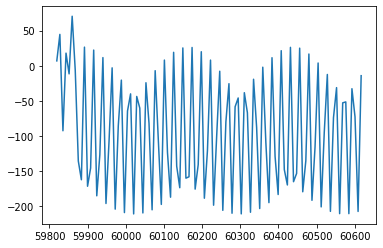

Iter 0060 | Total Loss 151.532013


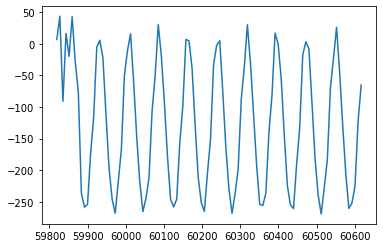

Iter 0065 | Total Loss 121.917648


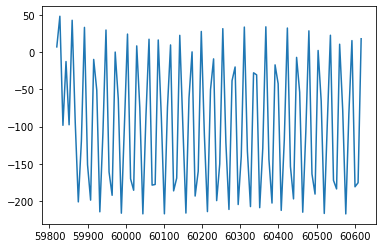

Iter 0070 | Total Loss 137.776199


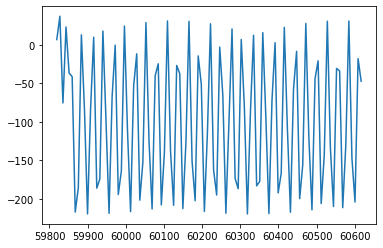

Iter 0075 | Total Loss 2391.428223


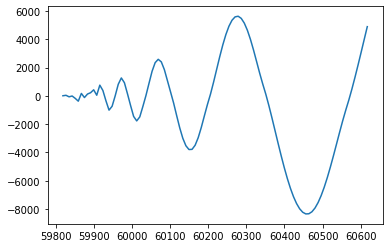

Iter 0080 | Total Loss 4586.106934


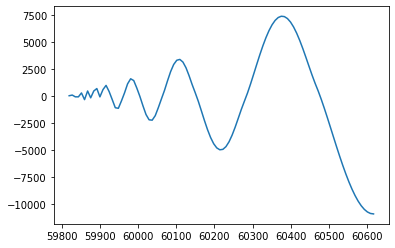

Iter 0085 | Total Loss 112.144989


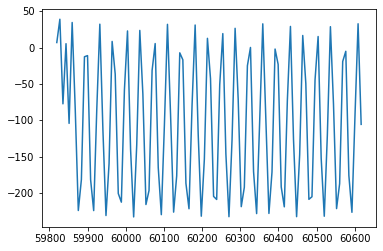

Iter 0090 | Total Loss 134.520126


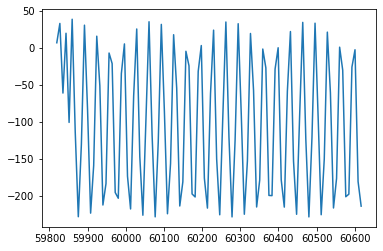

Iter 0095 | Total Loss 127.620949


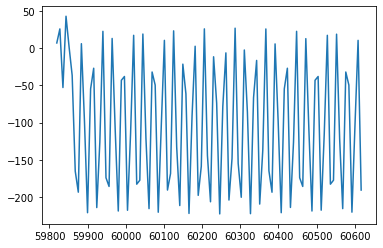

Iter 0100 | Total Loss 132.690948


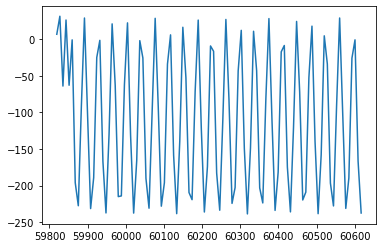

Iter 0005 | Total Loss 2146.049316


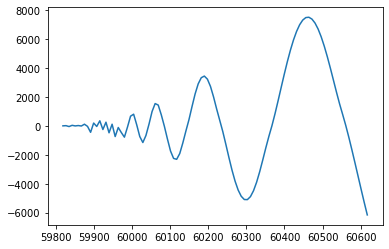

Iter 0010 | Total Loss 138.852722


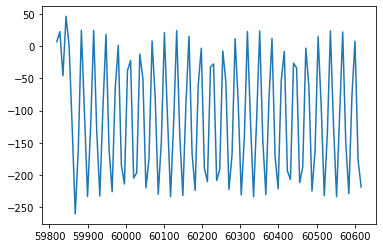

Iter 0015 | Total Loss 3438.287598


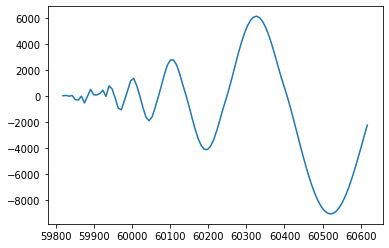

Iter 0020 | Total Loss 942.038940


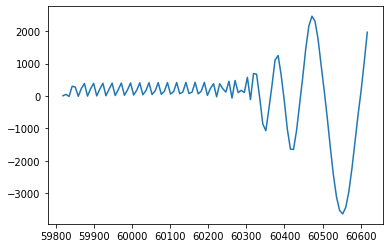

Iter 0025 | Total Loss 145.901657


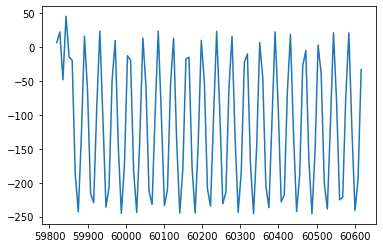

Iter 0030 | Total Loss 3514.305420


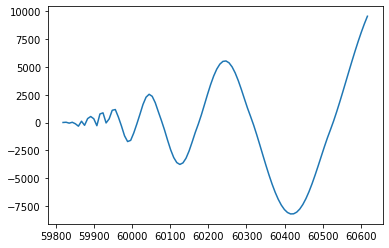

Iter 0035 | Total Loss 142.862762


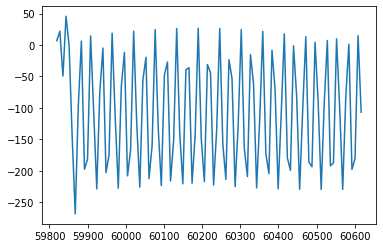

Iter 0040 | Total Loss 120.163322


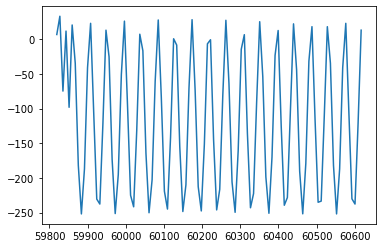

Iter 0045 | Total Loss 3611.980957


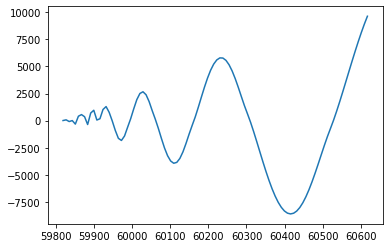

Iter 0050 | Total Loss 3544.556396


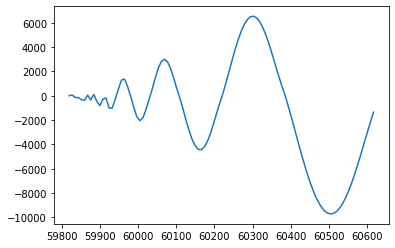

Iter 0055 | Total Loss 2556.429199


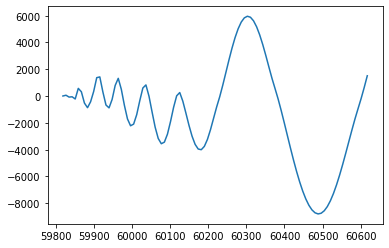

Iter 0060 | Total Loss 140.161545


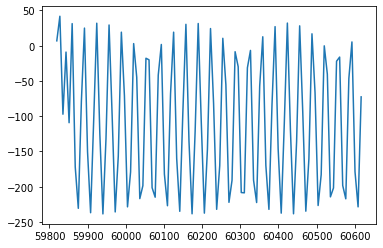

Iter 0065 | Total Loss 124.619438


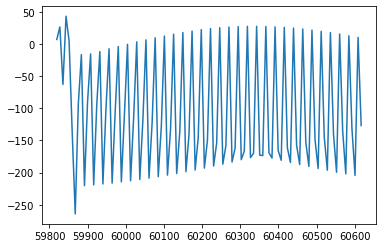

Iter 0070 | Total Loss 119.627411


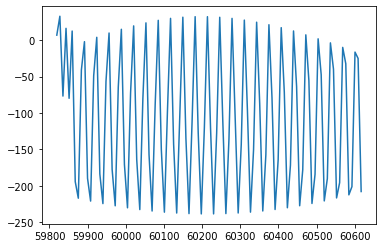

Iter 0075 | Total Loss 138.022766


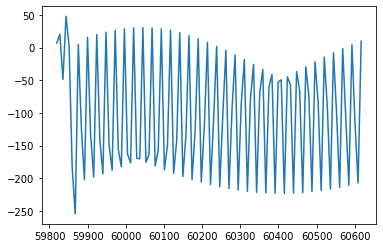

Iter 0080 | Total Loss 3894.369141


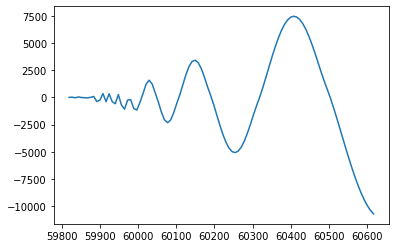

Iter 0085 | Total Loss 131.309692


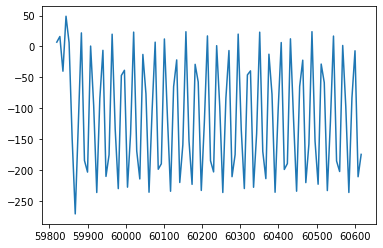

Iter 0090 | Total Loss 2469.525635


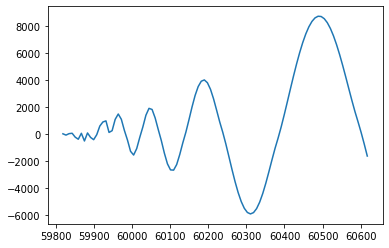

Iter 0095 | Total Loss 170.330933


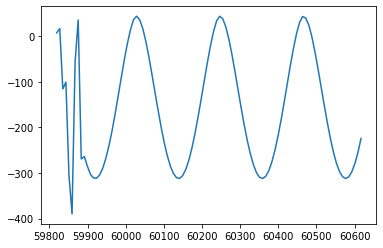

Iter 0100 | Total Loss 175.679520


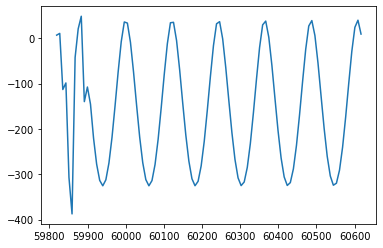

In [194]:
for epoch in range(1, epochs+1):    
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        by0_f, bt_f, by_f = ode_batch(times, fluxes)
        pred_f = odeint(odefunc, by0_f, bt_f, rtol=r_tol, atol=a_tol)
        loss = torch.mean(torch.abs(pred_f - by_f))
        loss.backward()
        optimizer.step()
#         print(itr)
        if itr % test_freq == 0:
            with torch.no_grad():
#                 clear_output()
                pred_interpolation = odeint(odefunc, flux_0, eval_times, rtol=r_tol, atol=a_tol)
                pred_f = odeint(odefunc, flux_0, times, rtol=r_tol, atol=a_tol)
        
                loss = torch.mean(torch.abs(pred_f - fluxes))
                losses.append(loss)
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                plt.plot(eval_times.tolist(), pred_interpolation.flatten().tolist())
                plt.show()
                ii += 1    

torch.Size([352, 1, 1])

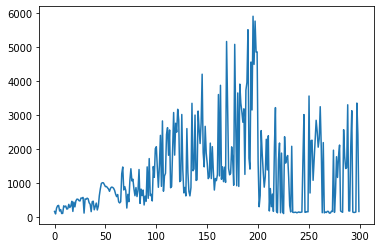

In [191]:
# print(losses)
# len(losses)
loss_over_time = [i for i in range(len(losses))]
# np.np(200)
# np_loss  = np.array(loss_over_time)
plt.plot(loss_over_time, losses)
# mjds.min()

pred_f = odeint(odefunc, flux_y0, mjds, rtol=.5, atol=.2)
# loss = torch.mean(torch.abs(pred_f - ))
pred_f.shape

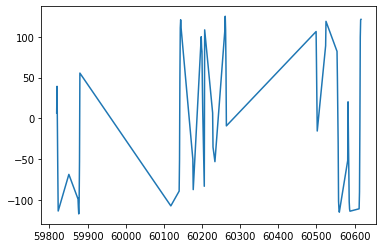

In [147]:
plt.plot(times.numpy(), flux_list.numpy())

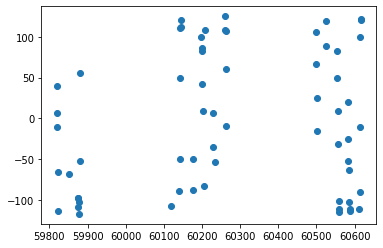

In [150]:
plt.scatter(times.numpy(), flux_list.numpy())
plt.show()